In [172]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import pandas as pd
# 导入精度和召回
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score

In [173]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
test['Survived'] = -1
data = train.append(test).reset_index(drop=True)

Text(0.5, 1.0, 'Percent missing data by feature')

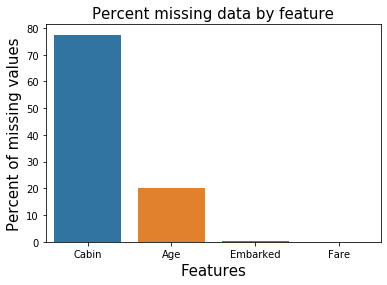

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
data_nan_per = (data.isnull().sum() / len(data)) * 100
data_nan_per = data_nan_per.drop(data_nan_per[data_nan_per == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio':data_nan_per})

sns.barplot(x = data_nan_per.index, y = data_nan_per)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [175]:
data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [176]:
# 空值太多，删除不要的列
data=data.drop(["Cabin"], axis=1)
# 填充空值
data["Embarked"]=data["Embarked"].fillna("S")
data["Age"]=data["Age"].fillna(data["Age"].mean())
data.isnull().sum()

Age            0
Embarked       0
Fare           1
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Survived       0
Ticket         0
dtype: int64

In [177]:
data.Survived.value_counts()

 0    549
-1    418
 1    342
Name: Survived, dtype: int64

In [178]:
cat_col = [i for i in data.select_dtypes(object).columns if i not in ['PassengerId','Survived','Name']]
for i in cat_col:
    lbl = LabelEncoder()
    data[i] = lbl.fit_transform(data[i].astype(str))

In [179]:
data.head()
# 所有特征
features = [i for i in data.columns if i not in ['PassengerId','Survived','Name']]
data.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0,720
1,38.0,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1,816
2,26.0,2,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1,914
3,35.0,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1,65
4,35.0,2,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0,649


In [180]:
# 搭建分类模型
import xgboost as xgb
import catboost as cbt
import lightgbm as lgb

xgb_model  = xgb.XGBClassifier(learning_rate=0.1,
                      n_estimators=1000,         
                       max_depth=6,               
                       min_child_weight = 1,      
                      gamma=0.,                  
                      subsample=0.8,             
                       colsample_btree=0.8,       
                       objective='binary:logistic', 
                      scale_pos_weight=1,        
                     random_state=27,
                    tree_method='gpu_hist'     
                      )
lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt", num_leaves=15, reg_alpha=0, reg_lambda=0.,
    max_depth=-1, n_estimators=1500, objective='binary',metric= 'auc',
    subsample=0.95, colsample_bytree=0.95, subsample_freq=1,
    learning_rate=0.05, random_state=2017
    )
cbt_model = cbt.CatBoostClassifier(iterations=5000,learning_rate=0.2,max_depth=7,
                                           l2_leaf_reg=1,verbose=100,early_stopping_rounds=500,task_type='GPU',
                                            eval_metric='AUC',cat_features=cat_col)

In [181]:
data_pre1,test_pre1,feature_importances1  = get_predict_w(xgb_model,data,label='Survived',feature=features,cate_feature=cat_col, random_state=2018, n_splits=5,
                  model_type='xgb')

[13:51:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.88481	validation_1-auc:0.84728
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.90576	validation_1-auc:0.86501
[2]	validation_0-auc:0.90819	validation_1-auc:0.86977
[3]	validation_0-auc:0.91065	validation_1-auc:0.87806
[4]	validation_0-auc:0.91747	validation_1-auc:0.87520
[5]	validation_0-auc:0.91754	validation_1-auc:0.87554
[6]	validation_0-auc:0.92000	validation_1-auc:0.87174
[7]	validation_0-auc:0.92254	validation_1-auc:0.87201
[8]	validation_0-a

[42]	validation_0-auc:0.97057	validation_1-auc:0.91242
[43]	validation_0-auc:0.97125	validation_1-auc:0.91270
[44]	validation_0-auc:0.97193	validation_1-auc:0.91339
[45]	validation_0-auc:0.97259	validation_1-auc:0.91380
[46]	validation_0-auc:0.97297	validation_1-auc:0.91422
[47]	validation_0-auc:0.97346	validation_1-auc:0.91422
[48]	validation_0-auc:0.97408	validation_1-auc:0.91422
[49]	validation_0-auc:0.97435	validation_1-auc:0.91436
[50]	validation_0-auc:0.97509	validation_1-auc:0.91380
[51]	validation_0-auc:0.97540	validation_1-auc:0.91366
[52]	validation_0-auc:0.97594	validation_1-auc:0.91339
[53]	validation_0-auc:0.97656	validation_1-auc:0.91366
[54]	validation_0-auc:0.97700	validation_1-auc:0.91366
[55]	validation_0-auc:0.97797	validation_1-auc:0.91408
[56]	validation_0-auc:0.97814	validation_1-auc:0.91449
[57]	validation_0-auc:0.97837	validation_1-auc:0.91463
[58]	validation_0-auc:0.97897	validation_1-auc:0.91422
[59]	validation_0-auc:0.97949	validation_1-auc:0.91449
[60]	valid

[190]	validation_0-auc:0.99915	validation_1-auc:0.92188
[191]	validation_0-auc:0.99920	validation_1-auc:0.92188
[192]	validation_0-auc:0.99922	validation_1-auc:0.92160
[193]	validation_0-auc:0.99924	validation_1-auc:0.92188
[194]	validation_0-auc:0.99930	validation_1-auc:0.92174
[195]	validation_0-auc:0.99929	validation_1-auc:0.92105
[196]	validation_0-auc:0.99932	validation_1-auc:0.92063
[197]	validation_0-auc:0.99929	validation_1-auc:0.92077
[198]	validation_0-auc:0.99930	validation_1-auc:0.92174
[199]	validation_0-auc:0.99930	validation_1-auc:0.92132
[200]	validation_0-auc:0.99933	validation_1-auc:0.92132
[201]	validation_0-auc:0.99932	validation_1-auc:0.92146
[202]	validation_0-auc:0.99941	validation_1-auc:0.92091
[203]	validation_0-auc:0.99944	validation_1-auc:0.92146
[204]	validation_0-auc:0.99943	validation_1-auc:0.92105
[205]	validation_0-auc:0.99940	validation_1-auc:0.92008
[206]	validation_0-auc:0.99943	validation_1-auc:0.92036
Stopping. Best iteration:
[156]	validation_0-auc

[50]	validation_0-auc:0.97901	validation_1-auc:0.89110
[51]	validation_0-auc:0.97992	validation_1-auc:0.89344
[52]	validation_0-auc:0.98104	validation_1-auc:0.89386
[53]	validation_0-auc:0.98123	validation_1-auc:0.89344
[54]	validation_0-auc:0.98161	validation_1-auc:0.89455
[55]	validation_0-auc:0.98242	validation_1-auc:0.89358
[56]	validation_0-auc:0.98248	validation_1-auc:0.89317
[57]	validation_0-auc:0.98236	validation_1-auc:0.89400
[58]	validation_0-auc:0.98288	validation_1-auc:0.89303
[59]	validation_0-auc:0.98368	validation_1-auc:0.89234
[60]	validation_0-auc:0.98401	validation_1-auc:0.89123
[61]	validation_0-auc:0.98443	validation_1-auc:0.89096
[62]	validation_0-auc:0.98475	validation_1-auc:0.89096
[63]	validation_0-auc:0.98536	validation_1-auc:0.88903
[64]	validation_0-auc:0.98630	validation_1-auc:0.88820
[65]	validation_0-auc:0.98646	validation_1-auc:0.88944
[66]	validation_0-auc:0.98670	validation_1-auc:0.88944
[67]	validation_0-auc:0.98719	validation_1-auc:0.88999
[68]	valid

In [182]:
data_pre2,test_pre2,feature_importances2  = get_predict_w(lgb_model,data,label='Survived',feature=features,cate_feature=cat_col, random_state=2018, n_splits=5,
                  model_type='lgb')

Training until validation scores don't improve for 100 rounds
[5]	training's auc: 0.906972	valid_1's auc: 0.853329
[10]	training's auc: 0.911357	valid_1's auc: 0.85163
[15]	training's auc: 0.91393	valid_1's auc: 0.853872
[20]	training's auc: 0.916122	valid_1's auc: 0.855435
[25]	training's auc: 0.918563	valid_1's auc: 0.855978
[30]	training's auc: 0.921601	valid_1's auc: 0.855435
[35]	training's auc: 0.924133	valid_1's auc: 0.856114
[40]	training's auc: 0.927274	valid_1's auc: 0.858016
[45]	training's auc: 0.929562	valid_1's auc: 0.861413
[50]	training's auc: 0.931874	valid_1's auc: 0.863451
[55]	training's auc: 0.935219	valid_1's auc: 0.86413
[60]	training's auc: 0.937991	valid_1's auc: 0.869429
[65]	training's auc: 0.940801	valid_1's auc: 0.871196
[70]	training's auc: 0.943093	valid_1's auc: 0.871467
[75]	training's auc: 0.945475	valid_1's auc: 0.871875
[80]	training's auc: 0.947871	valid_1's auc: 0.872418
[85]	training's auc: 0.949566	valid_1's auc: 0.874049
[90]	training's auc: 0.9

[100]	training's auc: 0.956618	valid_1's auc: 0.865631
[105]	training's auc: 0.958918	valid_1's auc: 0.866046
[110]	training's auc: 0.960726	valid_1's auc: 0.863285
[115]	training's auc: 0.962551	valid_1's auc: 0.861491
[120]	training's auc: 0.964533	valid_1's auc: 0.861215
[125]	training's auc: 0.965376	valid_1's auc: 0.859144
[130]	training's auc: 0.966796	valid_1's auc: 0.85804
[135]	training's auc: 0.968085	valid_1's auc: 0.860386
[140]	training's auc: 0.969654	valid_1's auc: 0.86011
[145]	training's auc: 0.970525	valid_1's auc: 0.861491
[150]	training's auc: 0.971467	valid_1's auc: 0.860801
[155]	training's auc: 0.972532	valid_1's auc: 0.859696
[160]	training's auc: 0.973597	valid_1's auc: 0.86011
[165]	training's auc: 0.974374	valid_1's auc: 0.859558
[170]	training's auc: 0.975216	valid_1's auc: 0.858868
[175]	training's auc: 0.976141	valid_1's auc: 0.857902
Early stopping, best iteration is:
[75]	training's auc: 0.944948	valid_1's auc: 0.873361
Training until validation scores d

In [183]:
data_pre3,test_pre3,feature_importances3 = get_predict_w(cbt_model,data,label='Survived',feature=features,cate_feature=cat_col, random_state=2018, n_splits=5,
                  model_type='ctb')

0:	learn: 0.8118639	test: 0.8031929	best: 0.8031929 (0)	total: 56.1ms	remaining: 4m 40s
100:	learn: 0.9075274	test: 0.8919157	best: 0.8991168 (61)	total: 5.65s	remaining: 4m 34s
bestTest = 0.8991168439
bestIteration = 61
Shrink model to first 62 iterations.
0:	learn: 0.7991015	test: 0.8595583	best: 0.8595583 (0)	total: 55.7ms	remaining: 4m 38s
100:	learn: 0.9015617	test: 0.9188406	best: 0.9188406 (97)	total: 5.62s	remaining: 4m 32s
200:	learn: 0.9104769	test: 0.9115252	best: 0.9195307 (111)	total: 10.4s	remaining: 4m 8s
bestTest = 0.9195306897
bestIteration = 111
Shrink model to first 112 iterations.
0:	learn: 0.8079799	test: 0.8239150	best: 0.8239150 (0)	total: 45.8ms	remaining: 3m 48s
100:	learn: 0.9154927	test: 0.8752068	best: 0.8835433 (25)	total: 5.36s	remaining: 4m 19s
bestTest = 0.8835433424
bestIteration = 25
Shrink model to first 26 iterations.
0:	learn: 0.8072775	test: 0.8071774	best: 0.8071774 (0)	total: 53.7ms	remaining: 4m 28s
100:	learn: 0.9136729	test: 0.9004141	best: 0.

In [184]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = feature_importances3['feature']
feature_importance['value'] = feature_importances3.drop(['feature'], axis=1).sum(axis=1)
feature_importance['value'] = feature_importance['value'] / 5
feature_importance = feature_importance.sort_values(by='value', ascending=False)

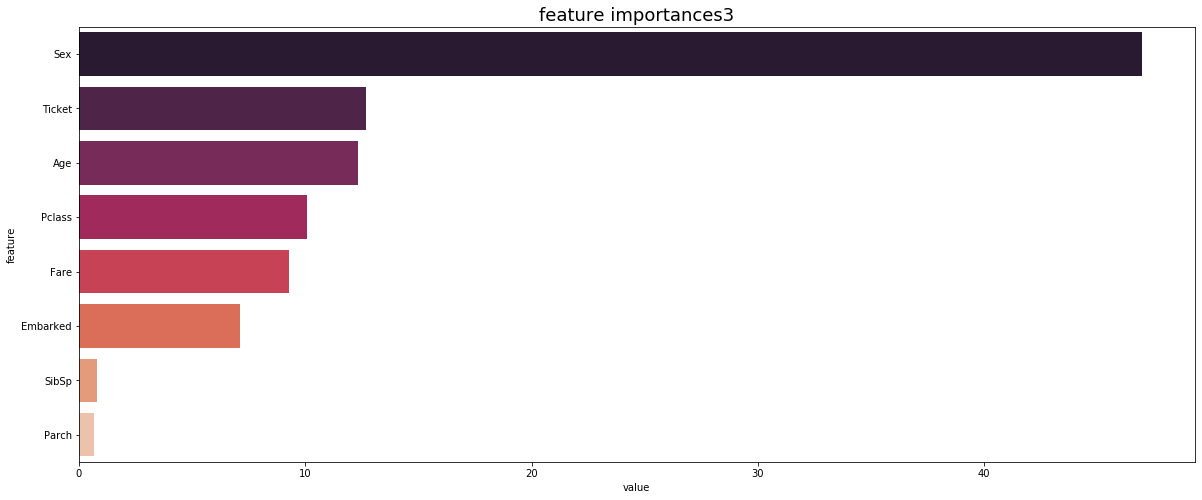

In [185]:
# 特征重要性可视化
plt.figure(figsize=(20, 8))
plt.title('feature importances3', fontsize=18)
sns.barplot(data=feature_importance, x='value', y='feature', palette='rocket')

In [186]:
# stacking
datax = pd.concat([data_pre1,data_pre2,data_pre3],axis=1)
y =data[data['Survived']!=-1]['Survived']

testx = pd.concat([test_pre1,test_pre2,test_pre3],axis=1)
res=data[data['Survived']==-1][['PassengerId']]
res['Survived'] = 0

In [187]:
# 检查维度
y.shape,datax.shape

((891,), (891, 3))

In [189]:
from sklearn.linear_model import LogisticRegression

def sigmoid(z):  
    return 1.0 / (1.0 + np.exp(-z)) 
lr = LogisticRegression( random_state=0)

lr.fit(datax, y)
sub = pd.DataFrame()
sub['PassengerId']=res['PassengerId']
sub['Survived']=lr.predict_proba(testx)[:,1]


sub.to_csv('Stacking.csv',index=False)